# Paramter Inference with Matter Power Spectra

In [1]:
import sys, os
from matplotlib import pyplot as plt
import numpy as np
import camb
import pickle

from pyPIPS.datasets import Datapoint, Dataset

In [2]:
def get_matter_ps(params):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=params["H0"], ombh2=params["ombh2"], omch2=params["omch2"], mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
    
    pars.set_matter_power(redshifts=np.arange(10, 0, -1), kmax=1)
    pars.NonLinear = camb.model.NonLinear_both
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1, npoints = 10)
    
    return Datapoint(ks=kh_nonlin, zs=z_nonlin, P_kz=pk_nonlin.T, params=params)

(10, 10)


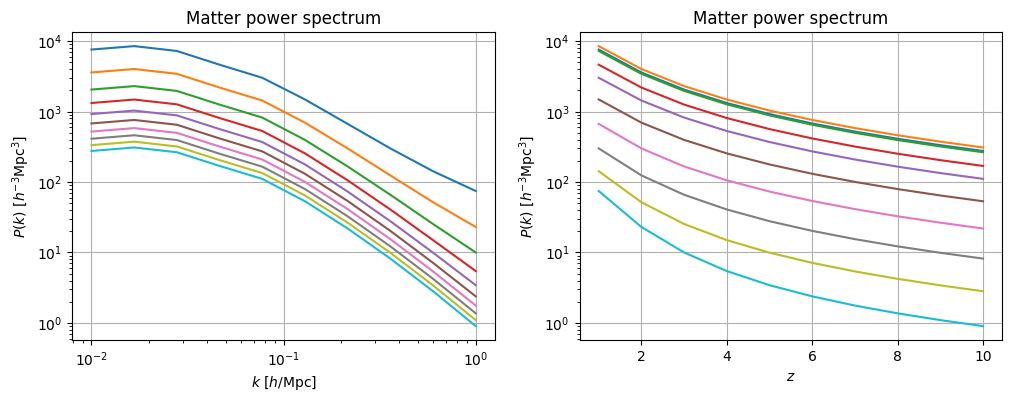

In [3]:
val = get_matter_ps({"H0": 67.5, "ombh2": 0.022, "omch2": 0.122})
print(val.P_kz.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.loglog(val.ks, val.P_kz)
ax1.grid()
ax1.set_xlabel(r"$k$ [$h$/Mpc]")
ax1.set_ylabel(r"$P(k)$ [$h^{-3}$Mpc$^3$]")
ax1.set_title("Matter power spectrum")
ax2.plot(val.zs, val.P_kz.T)
ax2.set_yscale("log")
ax2.grid()
ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"$P(k)$ [$h^{-3}$Mpc$^3$]")
ax2.set_title("Matter power spectrum")
plt.show()
plt.close()

In [4]:
dataset = Dataset()

dataset_save_file = "./data/matter.pkl"
if os.path.exists(dataset_save_file):
    with open(dataset_save_file, "rb") as f:
        dataset = pickle.load(f)
else:
    dataset = Dataset()
    dataset.generate_from_func(get_matter_ps, 1000, \
                               {"H0": [50, 100], "ombh2": [0.01, 0.05], "omch2": [0.01, 0.5]},
                               mp_threads=None)
    dataset.save(dataset_save_file)